In [23]:
img_width = 28
img_height = 28
channels = 1
batch_size = 500
num_epochs = 80
iterations = 3
nb_augmentation = 2
fashion_classes = {
    0:'T恤',
    1:'裤子',
    2:'套衫',
    3:'裙子',
    4:'外套',
    5:'凉鞋',
    6:'汗衫',
    7:'运动鞋',
    8:'包',
    9:'踝靴'
}
mnist_classes = [i for i in range(10)]
num_classes = 10

# 加载数据

In [22]:
import tensorflow_datasets as tfds
#训练集
train_fasion_mnist = tfds.as_numpy(tfds.load("fashion_mnist", split="train", data_dir = "./", download=False, batch_size=-1))
X_train, y_train = train_fasion_mnist["image"], train_fasion_mnist["label"]
#测试集
test_fasion_mnist = tfds.as_numpy(tfds.load("fashion_mnist", split="test", data_dir = "./", download=False, batch_size=-1))
X_test, y_test = test_fasion_mnist["image"], test_fasion_mnist["label"]
print("Train Samples:", len(X_train))
print("Test Samples:", len(X_test))

Train Samples: 60000
Test Samples: 10000


# 绘制一张随机样本

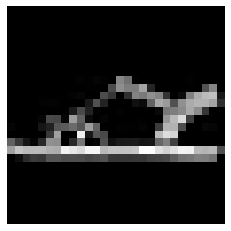

Target: 凉鞋


In [4]:
import matplotlib.pyplot as plt
import numpy as np
#len(X_train)表示训练集大小60000
#np.random.randint(len(X_train))表示从1到60000随机选取一个值
idx = np.random.randint(len(X_train))
#以idx为索引，可视化这个随机样本，灰度图显示
plt.imshow(np.squeeze(X_train[idx]), cmap='gray')
plt.axis('off')
plt.show()
print("Target:", fashion_classes[y_train[idx]])

# 数据增强

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#定义用于增强的选项
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    fill_mode='nearest'
)
#定义图像增强函数
def image_augmentation(image, nb_of_augmentation):
    '''
    Generates new images bei augmentation
    image : 原始图像
    nb_augmentation: 增加的数量
    images: 得到的新的图像
    '''
    images = []
    image = image.reshape(1, img_height, img_width, channels)
    i = 0
    for x_batch in datagen.flow(image, batch_size=1):
        images.append(x_batch)
        i += 1
        if i >= nb_of_augmentation:
            break
    return images

# 数据预处理

In [6]:
import tensorflow as tf
def preprocess_data(images, targets, use_augmentation=False, nb_of_augmentation=1):
    '''
    images: 原始图像
    targets: 目标标签
    use_augmentation: 如果进行数据增强则将其设定为True
    nb_of_augmentation: 如果use_augmentation=True，设置增强的数量
    '''
    X = []
    y = []
    for x_, y_ in zip(images, targets):
        #将像素点缩放为0.0-1.0
        x_ = x_ / 255.
        #数据增强
        if use_augmentation:
            argu_img = image_augmentation(x_, nb_of_augmentation)
            for a in argu_img:
                X.append(a.reshape(img_height, img_width, channels))
                y.append(y_)
                
        X.append(x_)
        y.append(y_)
        
    print('*预处理完成：%i 个样本\n' % len(X))
    
#     for item in X:
#         if item.shape!=(28,28,1):
#             X.remove(item)
            
#     print(len(X)) #you'll know how many corrupt sized images you had
    
    return np.array(X), tf.keras.utils.to_categorical(y)

In [7]:
X_train_shaped, y_train_shaped = preprocess_data(
X_train, y_train,
use_augmentation=True,
nb_of_augmentation=nb_augmentation
)
X_test_shaped, y_test_shaped = preprocess_data(X_test, y_test)

*预处理完成：180000 个样本

*预处理完成：10000 个样本



# 模型定义

In [8]:
def create_model():
    #创建简单的序贯模型
    #使用keras的squentail搭建神经网络模型时使用add进行一层一层的搭建
    cnn = tf.keras.Sequential()
    #添加输入层
    cnn.add(tf.keras.layers.InputLayer(input_shape=(img_height,img_width,channels)))
    #BatchNormalization(BN)可以防止梯度爆炸或弥散、可以提高训练时模型对不同超参（学习率、初始化）的鲁棒性、
    #可以让大部分的激活函数能够远离其饱和区域
    cnn.add(tf.keras.layers.BatchNormalization())
    #卷积层和池化层
    cnn.add(tf.keras.layers.Convolution2D(64, (4, 4), padding='same', activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    #Dropout
    #是一种防止过拟合的手段
    cnn.add(tf.keras.layers.Dropout(0.1))
    #卷积层和池化层
    cnn.add(tf.keras.layers.Convolution2D(64, (4, 4), activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    #Dropout
    cnn.add(tf.keras.layers.Dropout(0.3))
    #将3维特征向量转换成1维特征向量
    cnn.add(tf.keras.layers.Flatten())
    #全连接层
    #激活函数采用rule
    cnn.add(tf.keras.layers.Dense(256, activation='relu'))
    #Dropout
    cnn.add(tf.keras.layers.Dropout(0.5))
    #全连接层
    cnn.add(tf.keras.layers.Dense(64, activation='relu'))
    #Normalization
    cnn.add(tf.keras.layers.BatchNormalization())
    #激活函数采用softmax
    #softmax被用于多分类问题
    cnn.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    #相当于一个汇总，损失函数采用交叉熵，优化器选择adam，评估指标选用准确率
    cnn.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
    return cnn
create_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0

# 训练执行

In [9]:
from sklearn.model_selection import train_test_split
histories = []
#为了短时间内演示每个iter的准确性和损失曲线，可以减少训练次数。
#较多训练次数产生的checkpoint .可以参见models文件里的文件
for i in range(0,iterations):
    print('iteration:%i' % i)
    #每个iter中最佳checkpoit的保存路径
    filepath = "fashion_mnist-%i.hdf5" % i
    #数据划分
    X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_shaped, y_train_shaped,test_size=0.2, random_state=42)
    #创建模型并执行模型
    cnn = create_model()
    history = cnn.fit(X_train_, y_train_,
                      batch_size=batch_size,
                      epochs=2,#num_epochs,
                      verbose=1,
                      validation_data=(X_val_, y_val_),
                      callbacks=[
                          tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1,  save_best_only=True)
                      ])
    histories.append(history.history)

iteration:0
Epoch 1/2
288/288 [==============================] - ETA: 0s - loss: 0.5785 - accuracy: 0.7936
Epoch 00001: val_loss improved from inf to 0.50423, saving model to fashion_mnist-0.hdf5
288/288 [==============================] - 103s 359ms/step - loss: 0.5785 - accuracy: 0.7936 - val_loss: 0.5042 - val_accuracy: 0.8673
Epoch 2/2
288/288 [==============================] - ETA: 0s - loss: 0.3540 - accuracy: 0.8713
Epoch 00002: val_loss improved from 0.50423 to 0.27804, saving model to fashion_mnist-0.hdf5
288/288 [==============================] - 103s 357ms/step - loss: 0.3540 - accuracy: 0.8713 - val_loss: 0.2780 - val_accuracy: 0.8969
iteration:1
Epoch 1/2
288/288 [==============================] - ETA: 0s - loss: 0.5758 - accuracy: 0.7941
Epoch 00001: val_loss improved from inf to 0.54461, saving model to fashion_mnist-1.hdf5
288/288 [==============================] - 101s 350ms/step - loss: 0.5758 - accuracy: 0.7941 - val_loss: 0.5446 - val_accuracy: 0.8651
Epoch 2/2
288/2

# 模型评估

# 以最小损失值作为标准来进行模型的保存。（可选）

In [10]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
                         
print('训练集: \t%0.8f loss / %0.8f acc'%(get_avg(histories, 'loss'), get_avg(histories, 'accuracy')))
print('验证集: \t%0.8f loss / %0.8f acc'%(get_avg(histories, 'val_loss'), get_avg(histories, 'val_accuracy')))

训练集: 	0.35562709 loss / 0.87053009 acc
验证集: 	0.27957443 loss / 0.89660186 acc


# 确定所有模型的损失和准确性。

# 绘制每个iter的准确性和损失曲线（可选）

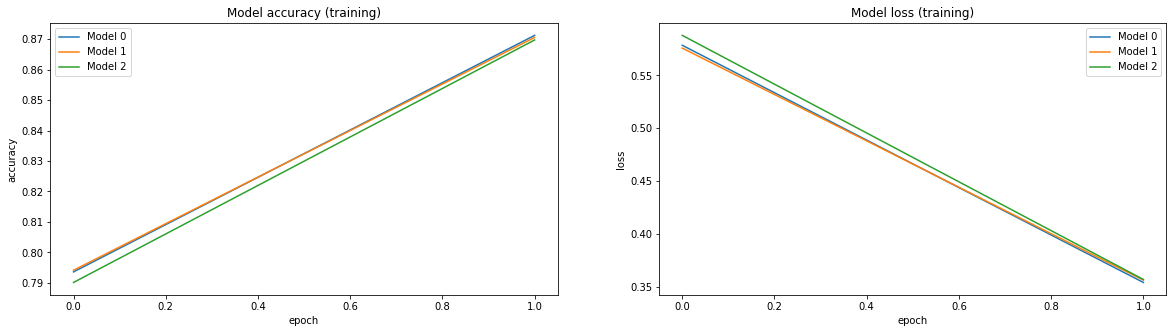

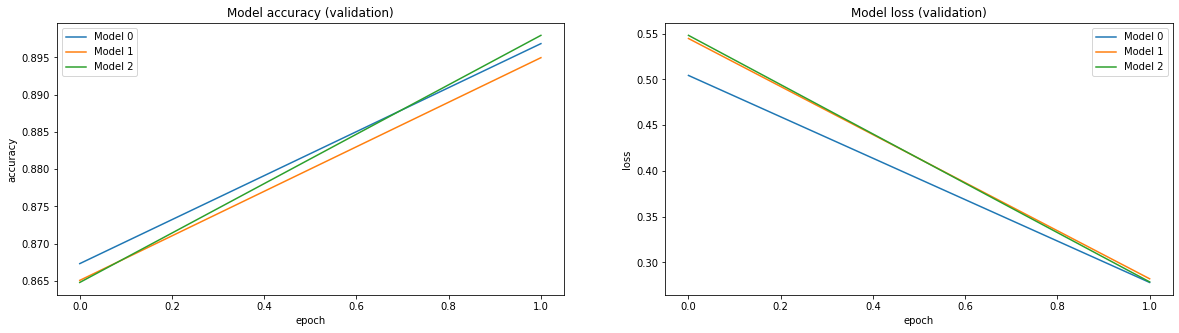

In [11]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig,(ax1, ax2) = plt.subplots(1,2)
                         
    #准确率
    ax1.set_title('Model accuracy (%s)' % title)
    names =[]
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % i)
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='upper left')
               
    #损失
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20,5)
    plt.show()
               
plot_acc_loss('training', histories,'accuracy', 'loss')
plot_acc_loss('validation', histories, 'val_accuracy','val_loss')

# 使用单模型评估


# 选择其中一个iter中的模型进行评估

In [12]:
RUN = 0
model = create_model()
model.load_weights("models/fashion_mnist-%i.hdf5" % RUN)

# 单模型绘制准确性和损失曲线（可选）

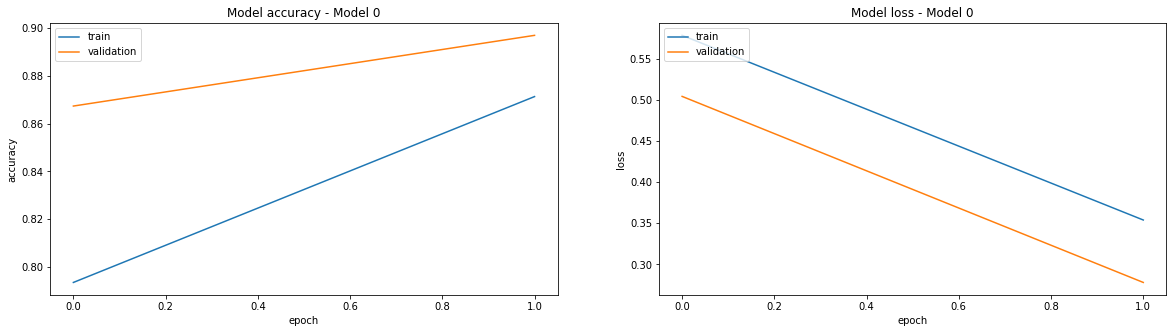

In [13]:
def plot_train_val(title,history ):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    #Accuracy
    ax1.set_title('Model accuracy - %s' % title)
    ax1.plot(history['accuracy'])
    ax1.plot(history['val_accuracy'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')
    #Loss
    ax2.set_title('Model loss - %s' % title)
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(['train', 'validation'], loc='upper left')
    fig.set_size_inches(20, 5)
    plt.show()
plot_train_val('Model %i' % RUN, histories[RUN])

# 显示随机样本的预测结果

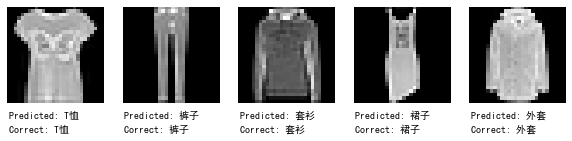

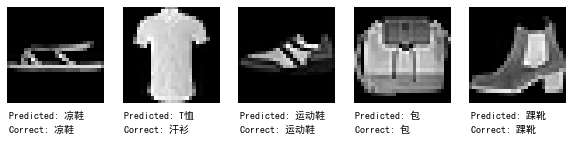

In [14]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams[ 'axes.unicode_minus']=False #用来正常显示负号
def plot_sample_predictions(classes, model, X_test, y_test):
    class_ = 0
    images_per_row = 5
    rows = len(classes)// images_per_row
    for i in range(rows):
        fig,axis = plt.subplots(1,images_per_row)
        for i,axis in enumerate(axis):
            elements = np.squeeze(np.argwhere(y_test ==class_))
            random = np.random.randint(len(elements))
            X = X_test[elements[random]]
            y = y_test[elements[random]]
            fig.set_size_inches(10,20)
            x_reshape = X.reshape([1,img_height,img_width,channels])
            axis.text(0,32, 'Predicted: {}'.format(classes[np.argmax(model.predict(x_reshape))]))
            axis.text(0,36, 'Correct: {}'.format((classes)[y]))
            axis.imshow(np.squeeze(X), cmap='gray')
            axis.axis('off')
            class_+=1
    plt.show()
plot_sample_predictions(list(fashion_classes.values()), model, X_test_shaped, y_test)

# 绘制混淆矩阵

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


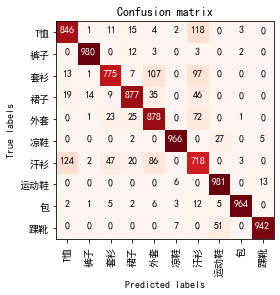

In [15]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, class_, title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(class_))
    plt.xticks(tick_marks, class_, rotation=90)
    plt.yticks(tick_marks, class_)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()
predictions = model.predict_classes(X_test_shaped, verbose=0)
plot_confusion_matrix(confusion_matrix(y_test, predictions), list(fashion_classes.values()))

# 返回 f1, precision 和 recall

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.89      0.78      0.83      1000
           3       0.91      0.88      0.89      1000
           4       0.78      0.88      0.83      1000
           5       0.98      0.97      0.97      1000
           6       0.67      0.72      0.70      1000
           7       0.92      0.98      0.95      1000
           8       0.99      0.96      0.98      1000
           9       0.98      0.94      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



# 自定义服装图片识别

# 加载模型权重

In [17]:
RUN = 0
model = create_model()
model.load_weights("models/fashion_mnist-%i.hdf5" % RUN)

# 显示我们测试的所有图片


['1.jpg', '10.jpg', '11.jpg', '12.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']


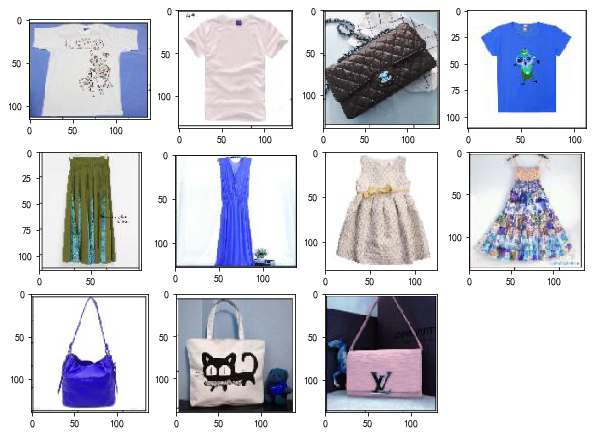

In [18]:
from PIL import Image
import matplotlib.pyplot as plt
import os
%matplotlib inline
file_dir = './testdata/'
data = []
for n in os.listdir(file_dir):
    if (n.lower().endswith(('.bmp', '.dib', '.png', '.jpg', '.jpeg', '.pbm', '.pgm', '.ppm', '.tif', '.tiff'))):
        data.append(n)
print(data)
plt.figure(figsize=(10,10))
m = len(data)
for i in range(1,m):
    plt.subplot(m/4+1,4,i)
    data_dir = file_dir + data[i]
    img=Image.open(data_dir)
    plt.imshow(img)
    
plt.show()

In [19]:
for n in os.listdir(file_dir):
    num=[]
    if(n.lower().endswith(('.bmp', '.dib', '.png', '.jpg', '.jpeg', '.pbm', '.pgm', '.ppm', '.tif', '.tiff'))):
        data_dir=file_dir+n
        #读取图片
        im=Image.open(data_dir)
        #将RGB彩色图像转换成灰度图像 0-255 0 最黑 255 最白
        im=im.convert("L")
        #将图片调整为28x28大小的图像 Image.ANTIALIAS高质量调整，清晰度更高点 Image.NEAREST 低质量调整
        im=im.resize((28,28),Image.ANTIALIAS)
        image_list=[]
        for x in range(28):
            scanline_list=[]
            for y in range(28):
                #获得这张图片每个像素的值
                pixel=im.getpixel((y,x))
                pixel=255.0*pixel
                pixel=pixel/255.0
                scanline_list.append(pixel)
            image_list.append(scanline_list)
        #转成模型能够接受的数据类型
        arr1=np.array(image_list).reshape((1,28,28,1))
        classes=list(fashion_classes.values())
        prediction=classes[np.argmax(model.predict(arr1))]
        print(n+"预测为："+prediction)


1.jpg预测为：踝靴
10.jpg预测为：外套
11.jpg预测为：外套
12.jpg预测为：包
2.jpg预测为：套衫
3.jpg预测为：汗衫
4.jpg预测为：裤子
5.jpg预测为：T恤
6.jpg预测为：汗衫
7.jpg预测为：套衫
8.jpg预测为：包
9.jpg预测为：包
